In [11]:
import numpy as np
import warnings
import litellm
import math
import os
import matplotlib.pyplot as plt
import random

custom_api_base = "https://litellmproxy.osu-ai.org/"
#OSU's LiteLLM proxy server.

from dotenv import load_dotenv
load_dotenv()
#Loading the .env file.

astro1221_key = os.getenv("ASTRO1221_API_KEY")
#Class API key.
if astro1221_key:
    print("Key found")
else:
    print("Did not find key")
    
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")
#Removing unnecessary warnings.

Key found


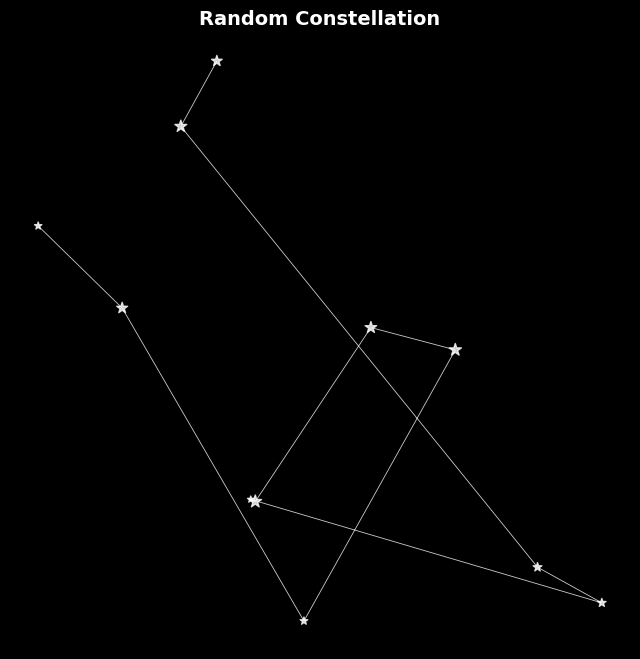

In [3]:
num_stars = random.randrange(10, 20)
def generate_random_constellation(num_stars= random.randrange(10, 20), num_connections= random.randrange(4, 9)):
    #This is to make it easier to call this definition for later constellations.
    if num_stars<12:
        num_connections<6
        #Doing this makes sure that the constellation is only between a certain number of stars.

    fig, ax = plt.subplots(figsize=(8,8), facecolor= 'black')
    ax.set_facecolor("black")
    #Makes the background of the plot black, a stylistic choice.

    x_vals = np.random.uniform(0, 10, num_stars)
    y_vals = np.random.uniform(0, 10, num_stars)
    #Randomizes the location of the stars.

    Constellations = {
        "X-Coordinates": [x_vals],
        "Y-Coordinates": [y_vals]
        }
    #Saves the coordinates into a dictionary.
    
    sizes = np.random.randint(20, 100, num_stars)
    #Randomizes the size of each star.

    ax.scatter(x_vals, y_vals, s=sizes, marker='*', color='white', alpha=0.8)
    #Plots stars.
    
    connections = np.random.choice(num_stars,(num_connections, 2), replace=True)
    #Randomizes the connections between stars.

    for start, end in connections:
        connection = plt.Line2D(x_vals, y_vals, linestyle='-', color='white', linewidth=.6, visible=True, alpha=.8)                 
    ax.add_line(connection)     
    #Draws lines to connect the stars.

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    #Sylistic choice, removes the axes.

    plt.title("Random Constellation", fontsize=14, fontweight="bold", color='white')
    
    fig.savefig(fname="astroplot.png")


generate_random_constellation()

In [9]:
for c in connections:
    distance = math.sqrt(x_vals**2+y_vals**2)
if distance < 1:
    plt.Line2D()

NameError: name 'connections' is not defined

In [13]:
import base64

# Opening the file and reading it as binary
with open("astroplot.png", "rb") as f:
    # Reading the image as binary and converting to Base64
    encoded_image = base64.b64encode(f.read()).decode('utf-8')
    

# Prompting the LLM and setting max token values
response = litellm.completion(
    model = "openai/GPT-4.1-mini",
    messages = [
        {"role": "system", "content": "You are a Greek theologian, and have to create a story from the given stars. Use Greek myth stories as a base for these."},
        #Context for the LLM
        {"role": "user", "content": [
            {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{encoded_image}"}}
            #The encoded image being sent to the LLM
        ]}
    ],
    max_tokens = 1000,
    api_base=custom_api_base,
    api_key=astro1221_key,
    temperature=.3
    #LiteLLM Parameters
    )
print(response)

ModelResponse(id='chatcmpl-DAlI5HKNIND5AIZef5xNnIcAsUeok', created=1771457437, model='gpt-4.1-mini-2025-04-14', object='chat.completion', system_fingerprint='fp_b6f445fc1c', choices=[Choices(finish_reason='stop', index=0, message=Message(content='In the ancient Greek skies, there was a lesser-known constellation called "The Weaver\'s Thread." This constellation, formed by the stars in the image, tells the story of Arachne, a mortal woman gifted with extraordinary weaving skills.\n\nArachne was so talented that she dared to challenge the goddess Athena herself to a weaving contest. The gods watched as the two wove tapestries of unmatched beauty. Arachne\'s work depicted the flaws and follies of the gods, which angered Athena. In her wrath, Athena transformed Arachne into a spider, condemning her to weave forever.\n\nThe stars in this constellation trace the path of Arachne\'s thread, symbolizing the eternal cycle of creation and punishment. The lines connecting the stars represent the d